# Pleiades ML

In [145]:
#Functions for distance, x, y, and z
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

def distance(x):
    if x < 0:
        return 0
    else:
        return 1/x

def x(R, b, l):
    return R * math.cos(b*(math.pi/180)) * math.cos(l*(math.pi/180))

def y(R, b, l):
    return R * math.cos(b*(math.pi/180)) * math.sin(l*(math.pi/180))

def z(R, b):
    return R * math.sin(b*(math.pi/180))

def absmag(m, d):
    return (((math.log10(d) * 5)*-1)+5)+m

def badToGood(bad, everything):
    return bad/everything

#https://pages.uoregon.edu/soper/Light/luminosity.html
def luminosity(m, d):
    return 4*math.pi*math.pow(d, 2)*m

def solar_lum(l):
    return l/(3.828*math.pow(10, 26))

#σ = 5.670374419...×10−8 W⋅m−2⋅K−4
def radius(l, t):
    const = 5.67 * math.pow(10, -8)
    ans = l/(4*math.pi*const*math.pow(t, 4))
    return math.log10(math.sqrt(ans))

def uwe(chi2, good_obs):
    u = math.sqrt(chi2/(good_obs-5))
    return u

def ruwe(u, g, b_r):
    table = pd.read_csv("table_u0_g_col.csv")
    u0 = bilinear_interpolation(g, b_r, table.values)
    return u/u0

def bilinear_interpolation(x, y, points):
    '''Interpolate (x,y) from values associated with four points.

    The four points are a list of four triplets:  (x, y, value).
    The four points can be in any order.  They should form a rectangle.

        >>> bilinear_interpolation(12, 5.5,
        ...                        [(10, 4, 100),
        ...                         (20, 4, 200),
        ...                         (10, 6, 150),
        ...                         (20, 6, 300)])
        165.0

    '''
    # See formula at:  http://en.wikipedia.org/wiki/Bilinear_interpolation

    points = sorted(points)               # order points by x, then by y
    (x1, y1, q11), (_x1, y2, q12), (x2, _y1, q21), (_x2, _y2, q22) = points
    print(points)

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError('points do not form a rectangle')
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        raise ValueError('(x, y) not within the rectangle')

    return (q11 * (x2 - x) * (y2 - y) +
            q21 * (x - x1) * (y2 - y) +
            q12 * (x2 - x) * (y - y1) +
            q22 * (x - x1) * (y - y1)
           ) / ((x2 - x1) * (y2 - y1) + 0.0)

In [146]:
#SELECT * from gaiadr2.gaia_source where 
#RA between 50 and 60 AND
#DEC between 20 and 30 AND
#parallax > 6.2 AND parallax < 12.5
pleiades = pd.read_csv("pleiadesfinal.csv")
pleiades.loc[:, 'parallax_arcsec'] = pleiades['parallax'].apply(lambda x: x*.001)
pleiades.loc[:, 'R'] = pleiades['parallax_arcsec'].apply(distance)
pleiades.loc[:, 'x'] = pleiades.apply(lambda r: x(r['R'], r['b'], r['l']), axis=1)
pleiades.loc[:, 'y'] = pleiades.apply(lambda r: y(r['R'], r['b'], r['l']), axis=1)
pleiades.loc[:, 'z'] = pleiades.apply(lambda r: z(r['R'], r['b']), axis=1)
pleiades.loc[:, 'magnitude'] = pleiades.apply(lambda x: absmag(x['phot_g_mean_mag'], x['R']), axis=1)
pleiades.loc[:, 'luminosity'] = pleiades.apply(lambda x: luminosity(x['phot_g_mean_mag'], x['R']), axis=1)
pleiades.loc[:, 'solar_luminosity'] = pleiades.apply(lambda x: solar_lum(x['luminosity']), axis=1)
pleiades.loc[:, 'radius'] = pleiades.apply(lambda x: radius(x['luminosity'], x['teff_val']), axis=1)

In [147]:
asu = pd.read_csv("asupleiades.csv")

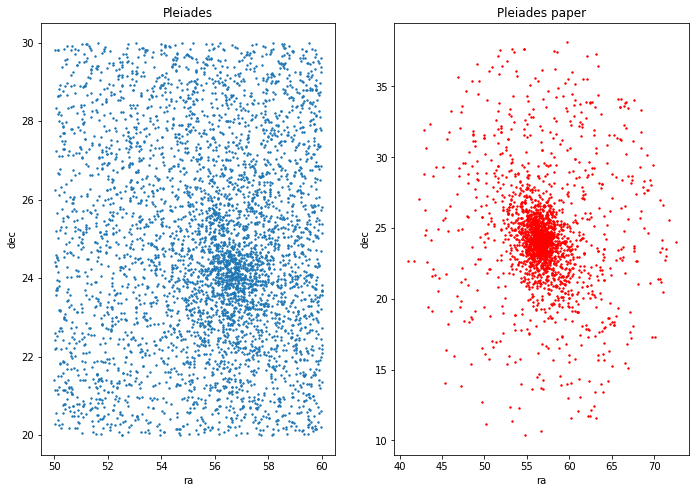

In [148]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.scatter(pleiades['ra'], pleiades['dec'], s=2)
ax.set_title('Pleiades')
ax.set_xlabel("ra")
ax.set_ylabel("dec")

ax2 = fig.add_subplot(122)
ax2.scatter(asu['RA_ICRS'], asu['DE_ICRS'], s=2, color='red')
ax2.set_title('Pleiades paper')
ax2.set_xlabel("ra")
ax2.set_ylabel("dec")

plt.subplots_adjust(0.2, 0.2, 1.7, 1.7)
plt.show()

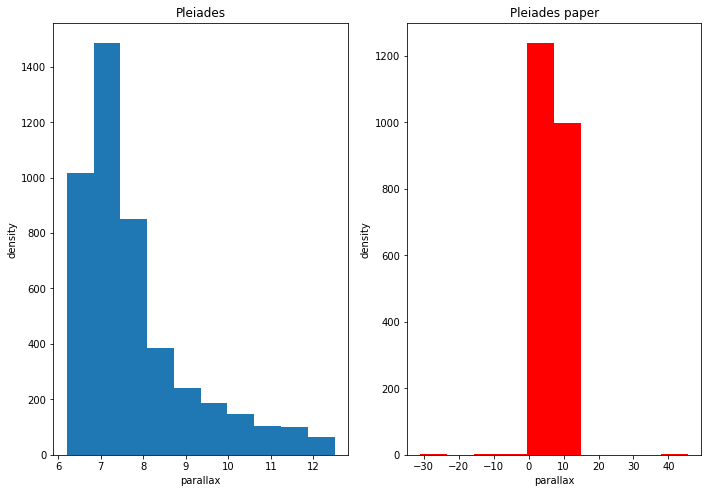

In [149]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.hist(pleiades['parallax'])
ax.set_title('Pleiades')
ax.set_xlabel("parallax")
ax.set_ylabel("density")

ax2 = fig.add_subplot(122)
ax2.hist(asu['PlxCP'], color='red')
ax2.set_title('Pleiades paper')
ax2.set_xlabel("parallax")
ax2.set_ylabel("density")

plt.subplots_adjust(0.2, 0.2, 1.7, 1.7)
plt.show()

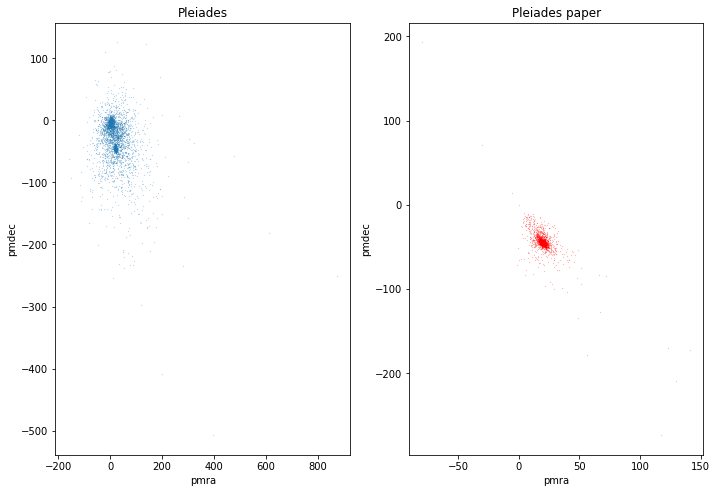

In [150]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.scatter(pleiades['pmra'], pleiades['pmdec'], s=0.01)
ax.set_title('Pleiades')
ax.set_xlabel("pmra")
ax.set_ylabel("pmdec")

ax2 = fig.add_subplot(122)
ax2.scatter(asu['pmRACP'], asu['pmDECP'], s=0.01, color='red')
ax2.set_title('Pleiades paper')
ax2.set_xlabel("pmra")
ax2.set_ylabel("pmdec")

plt.subplots_adjust(0.2, 0.2, 1.7, 1.7)
plt.show()

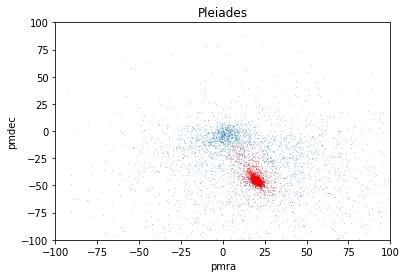

In [151]:
plt.scatter(pleiades['pmra'], pleiades['pmdec'], s=0.01)
plt.scatter(asu['pmRACP'], asu['pmDECP'], s=0.01, color='red')
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.title("Pleiades")
plt.xlabel("pmra")
plt.ylabel("pmdec")
plt.show()

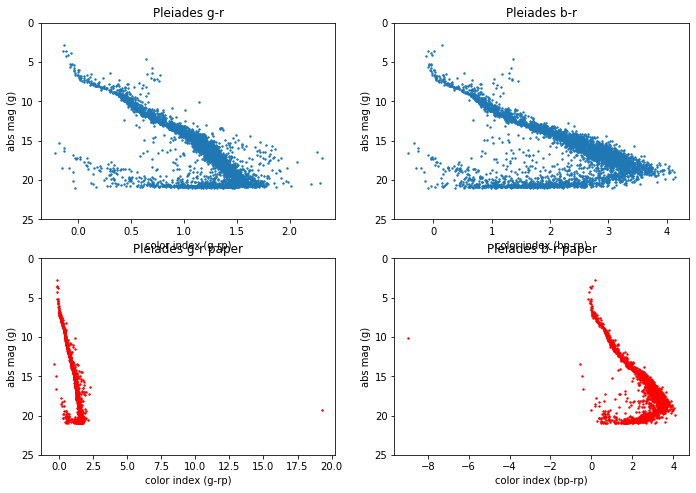

In [152]:
fig = plt.figure()
ax = fig.add_subplot(221)
ax.scatter(pleiades['g_rp'], pleiades['phot_g_mean_mag'], s=2)
ax.set_ylim(25, 0)
ax.set_title('Pleiades g-r')
ax.set_xlabel("color index (g-rp)")
ax.set_ylabel("abs mag (g)")

ax2 = fig.add_subplot(222)
ax2.scatter(pleiades['bp_rp'], pleiades['phot_g_mean_mag'], s=2)
ax2.set_ylim(25, 0)
ax2.set_title('Pleiades b-r')
ax2.set_xlabel("color index (bp-rp)")
ax2.set_ylabel("abs mag (g)")

ax3 = fig.add_subplot(223)
ax3.scatter(asu['G-R'], asu['Gmag'], s=2, color='red')
ax3.set_ylim(25, 0)
ax3.set_title('Pleiades g-r paper')
ax3.set_xlabel("color index (g-rp)")
ax3.set_ylabel("abs mag (g)")

ax4 = fig.add_subplot(224)
ax4.scatter(asu['B-R'], asu['Gmag'], s=2, color='red')
ax4.set_ylim(25, 0)
ax4.set_title('Pleiades b-r paper')
ax4.set_xlabel("color index (bp-rp)")
ax4.set_ylabel("abs mag (g)")

plt.subplots_adjust(0.2, 0.2, 1.7, 1.7)
plt.show()

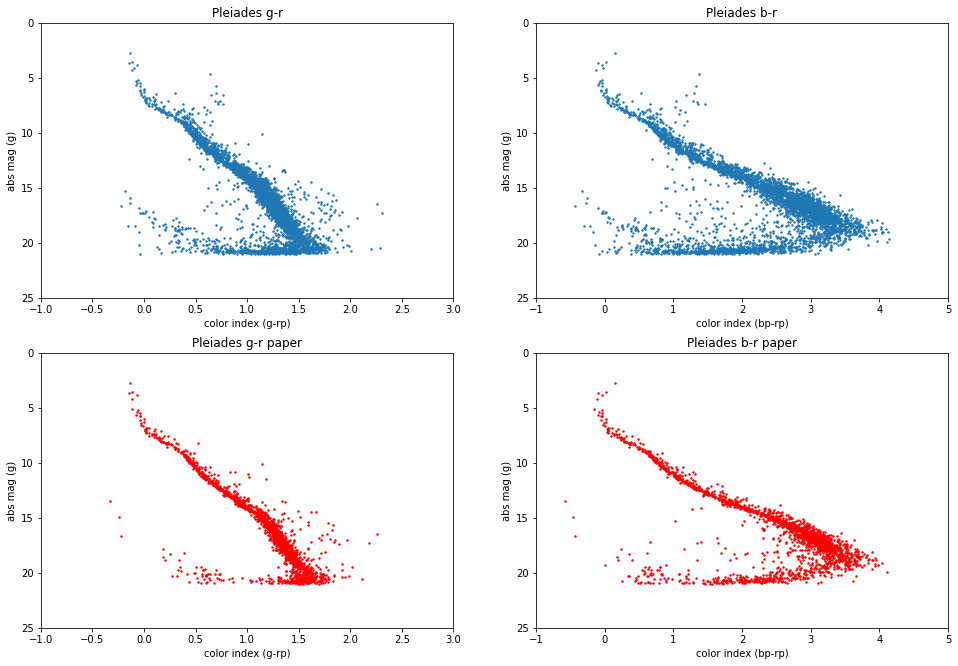

In [275]:
fig = plt.figure()
ax = fig.add_subplot(221)
ax.scatter(pleiades['g_rp'], pleiades['phot_g_mean_mag'], s=2)
ax.set_xlim(-1, 3)
ax.set_ylim(25, 0)
ax.set_title('Pleiades g-r')
ax.set_xlabel("color index (g-rp)")
ax.set_ylabel("abs mag (g)")

ax2 = fig.add_subplot(222)
ax2.scatter(pleiades['bp_rp'], pleiades['phot_g_mean_mag'], s=2)
ax2.set_xlim(-1, 5)
ax2.set_ylim(25, 0)
ax2.set_title('Pleiades b-r')
ax2.set_xlabel("color index (bp-rp)")
ax2.set_ylabel("abs mag (g)")

ax3 = fig.add_subplot(223)
ax3.scatter(asu['G-R'], asu['Gmag'], s=2, color='red')
ax3.set_xlim(-1, 3)
ax3.set_ylim(25, 0)
ax3.set_title('Pleiades g-r paper')
ax3.set_xlabel("color index (g-rp)")
ax3.set_ylabel("abs mag (g)")

ax4 = fig.add_subplot(224)
ax4.scatter(asu['B-R'], asu['Gmag'], s=2, color='red')
ax4.set_xlim(-1, 5)
ax4.set_ylim(25, 0)
ax4.set_title('Pleiades b-r paper')
ax4.set_xlabel("color index (bp-rp)")
ax4.set_ylabel("abs mag (g)")

plt.subplots_adjust(0.2, 0.2, 2.3, 2.3)
plt.show()

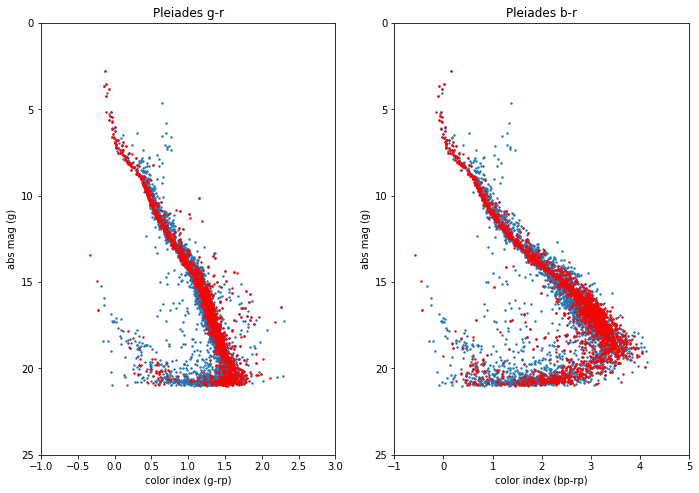

In [154]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.scatter(pleiades['g_rp'], pleiades['phot_g_mean_mag'], s=2)
ax.scatter(asu['G-R'], asu['Gmag'], s=2, color='red')
ax.set_xlim(-1, 3)
ax.set_ylim(25, 0)
ax.set_title('Pleiades g-r')
ax.set_xlabel("color index (g-rp)")
ax.set_ylabel("abs mag (g)")

ax2 = fig.add_subplot(122)
ax2.scatter(pleiades['bp_rp'], pleiades['phot_g_mean_mag'], s=2)
ax2.scatter(asu['B-R'], asu['Gmag'], s=2, color='red')
ax2.set_xlim(-1, 5)
ax2.set_ylim(25, 0)
ax2.set_title('Pleiades b-r')
ax2.set_xlabel("color index (bp-rp)")
ax2.set_ylabel("abs mag (g)")


plt.subplots_adjust(0.2, 0.2, 1.7, 1.7)
plt.show()

In [155]:
p = pleiades

#Trim data

#parallax error, if error is >= 1/10 of error/parallax, drop it
s = 1/10
for index, row in p.iterrows():
    if row['parallax_error']/row['parallax'] >= s:
        p = p.drop([index])

In [156]:
p = pleiades

#Trim data

#parallax error, if error is >= 1/10 of error/parallax, drop it
s = 1/10
for index, row in p.iterrows():
    if row['parallax_error']/row['parallax'] >= s:
        p = p.drop([index])
"""

#duplicate source, if star is a duplicate drop it
for index, row in p.iterrows():
    if row['duplicated_source'] == True:
        p = p.drop([index])

#astronometric excess noise, if the noise is >= 1 drop it
s = 1
for index, row in p.iterrows():
    if row['astrometric_excess_noise'] >= s:
        p = p.drop([index])

#visibility periods used, if less than 5 visibility periods drop it
s = 5
for index, row in p.iterrows():
    if row['visibility_periods_used'] <= s:
        p = p.drop([index])

#gmag, if gmag is greater than 19 drop it
#Can generalize it
s = 19
for index, row in p.iterrows():
    if row['phot_g_mean_mag'] > s:
        p = p.drop([index])

trimmed_df = p
df = p
a = 1/10
b = 1
c = 5
d = 19
print(df.columns)

for index, row in trimmed_df.iterrows():
    print(trimmed_df([index])
    # parallax error, if error is >= 1/10 of error/parallax, drop it
    #if 'parallax_error' in df.columns:
    if (row['parallax_error'] / row['parallax']) >= a:
        trimmed_df = trimmed_df.drop([index])

    if not trimmed_df.index.empty():
        # duplicate source, if star is a duplicate drop it
        if 'duplicated_source' in df.columns:
            if row['duplicated_source'] == True:
                trimmed_df = trimmed_df.drop([index])
        if not trimmed_df.index.empty():
            # astronometric excess noise, if the noise is >= 1 drop it
            if 'astrometric_excess_noise' in df.columns:
                if row['astrometric_excess_noise'] >= b:
                    trimmed_df = trimmed_df.drop([index])
            if not trimmed_df.index.empty():
                # visibility periods used, if less than 5 visibility periods drop it
                if 'visibility_periods_used' in df.columns:
                    if row['visibility_periods_used'] <= c:
                        trimmed_df = trimmed_df.drop([index])
                if not trimmed_df.index.empty():
                    # gmag, if gmag is greater than 19 drop it
                    if 'phot_g_mean_mag' in df.columns:
                        if row['phot_g_mean_mag'] > d:
                            trimmed_df = trimmed_df.drop([index])"""

"\n\n#duplicate source, if star is a duplicate drop it\nfor index, row in p.iterrows():\n    if row['duplicated_source'] == True:\n        p = p.drop([index])\n\n#astronometric excess noise, if the noise is >= 1 drop it\ns = 1\nfor index, row in p.iterrows():\n    if row['astrometric_excess_noise'] >= s:\n        p = p.drop([index])\n\n#visibility periods used, if less than 5 visibility periods drop it\ns = 5\nfor index, row in p.iterrows():\n    if row['visibility_periods_used'] <= s:\n        p = p.drop([index])\n\n#gmag, if gmag is greater than 19 drop it\n#Can generalize it\ns = 19\nfor index, row in p.iterrows():\n    if row['phot_g_mean_mag'] > s:\n        p = p.drop([index])\n\ntrimmed_df = p\ndf = p\na = 1/10\nb = 1\nc = 5\nd = 19\nprint(df.columns)\n\nfor index, row in trimmed_df.iterrows():\n    print(trimmed_df([index])\n    # parallax error, if error is >= 1/10 of error/parallax, drop it\n    #if 'parallax_error' in df.columns:\n    if (row['parallax_error'] / row['parallax

In [157]:
trimmed_df = pleiades
df = pleiades
a = 1/10
b = 1
c = 5
d = 19

#Trim data

#parallax error, if error is >= 1/10 of error/parallax, drop it
"""s = 1/10
for index, row in p.iterrows():
    if row['parallax_error']/row['parallax'] >= s:
        p = p.drop([index])
#a = 1/10
for index, row in trimmed_df.iterrows():
    if (row['parallax_error'] / row['parallax']) >= a:
        trimmed_df = trimmed_df.drop([index])"""

for index, row in trimmed_df.iterrows():
    # parallax error, if error is >= 1/10 of error/parallax, drop it
    #if 'parallax_error' in df.columns:
    if (row['parallax_error'] / row['parallax']) >= a:
        trimmed_df = trimmed_df.drop([index])
        index = None
    if index:
        # duplicate source, if star is a duplicate drop it
        if 'duplicated_source' in df.columns:
            if row['duplicated_source'] == True:
                trimmed_df = trimmed_df.drop([index])
                index = None
        if index:
            # astronometric excess noise, if the noise is >= 1 drop it
            if 'astrometric_excess_noise' in df.columns:
                if row['astrometric_excess_noise'] >= b:
                    trimmed_df = trimmed_df.drop([index])
                    index = None
            if index:
                # visibility periods used, if less than 5 visibility periods drop it
                if 'visibility_periods_used' in df.columns:
                    if row['visibility_periods_used'] <= c:
                        trimmed_df = trimmed_df.drop([index])
                        index = None
                if index:
                    # gmag, if gmag is greater than 19 drop it
                    if 'phot_g_mean_mag' in df.columns:
                        if row['phot_g_mean_mag'] > d:
                            trimmed_df = trimmed_df.drop([index])

p = trimmed_df

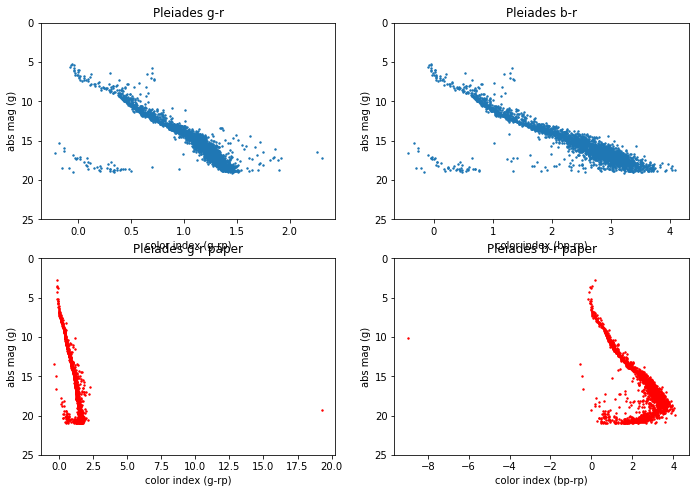

In [158]:
fig = plt.figure()
ax = fig.add_subplot(221)
ax.scatter(p['g_rp'], p['phot_g_mean_mag'], s=2)
ax.set_ylim(25, 0)
ax.set_title('Pleiades g-r')
ax.set_xlabel("color index (g-rp)")
ax.set_ylabel("abs mag (g)")

ax2 = fig.add_subplot(222)
ax2.scatter(p['bp_rp'], p['phot_g_mean_mag'], s=2)
ax2.set_ylim(25, 0)
ax2.set_title('Pleiades b-r')
ax2.set_xlabel("color index (bp-rp)")
ax2.set_ylabel("abs mag (g)")

ax3 = fig.add_subplot(223)
ax3.scatter(asu['G-R'], asu['Gmag'], s=2, color='red')
ax3.set_ylim(25, 0)
ax3.set_title('Pleiades g-r paper')
ax3.set_xlabel("color index (g-rp)")
ax3.set_ylabel("abs mag (g)")

ax4 = fig.add_subplot(224)
ax4.scatter(asu['B-R'], asu['Gmag'], s=2, color='red')
ax4.set_ylim(25, 0)
ax4.set_title('Pleiades b-r paper')
ax4.set_xlabel("color index (bp-rp)")
ax4.set_ylabel("abs mag (g)")

plt.subplots_adjust(0.2, 0.2, 1.7, 1.7)
plt.show()

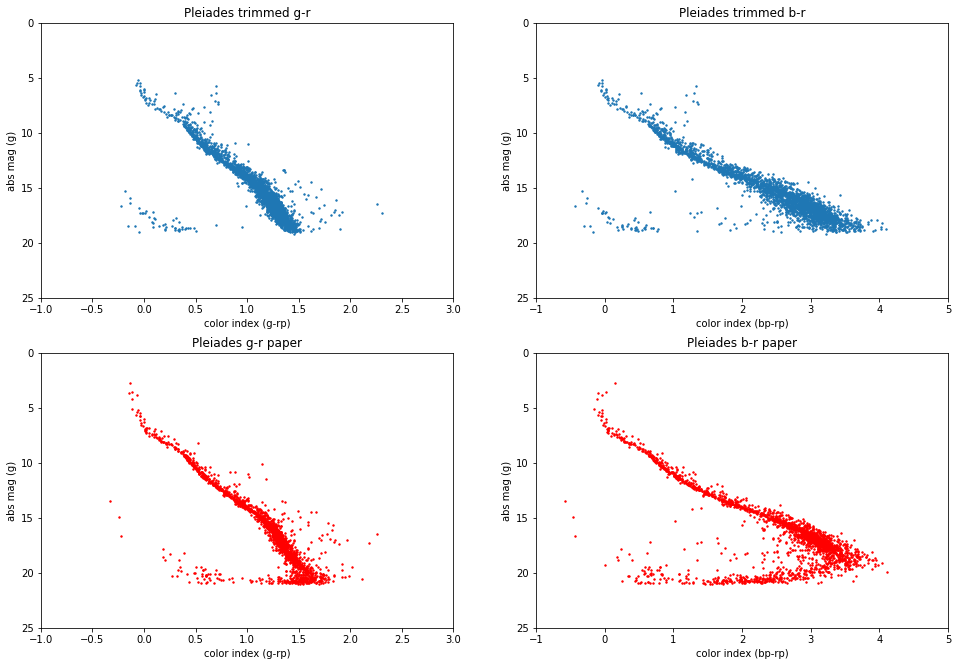

In [274]:
fig = plt.figure()
ax = fig.add_subplot(221)
ax.scatter(p['g_rp'], p['phot_g_mean_mag'], s=2)
ax.set_xlim(-1, 3)
ax.set_ylim(25, 0)
ax.set_title('Pleiades trimmed g-r')
ax.set_xlabel("color index (g-rp)")
ax.set_ylabel("abs mag (g)")

ax2 = fig.add_subplot(222)
ax2.scatter(p['bp_rp'], p['phot_g_mean_mag'], s=2)
ax2.set_xlim(-1, 5)
ax2.set_ylim(25, 0)
ax2.set_title('Pleiades trimmed b-r')
ax2.set_xlabel("color index (bp-rp)")
ax2.set_ylabel("abs mag (g)")

ax3 = fig.add_subplot(223)
ax3.scatter(asu['G-R'], asu['Gmag'], s=2, color='red')
ax3.set_xlim(-1, 3)
ax3.set_ylim(25, 0)
ax3.set_title('Pleiades g-r paper')
ax3.set_xlabel("color index (g-rp)")
ax3.set_ylabel("abs mag (g)")

ax4 = fig.add_subplot(224)
ax4.scatter(asu['B-R'], asu['Gmag'], s=2, color='red')
ax4.set_xlim(-1, 5)
ax4.set_ylim(25, 0)
ax4.set_title('Pleiades b-r paper')
ax4.set_xlabel("color index (bp-rp)")
ax4.set_ylabel("abs mag (g)")

plt.subplots_adjust(0.2, 0.2, 2.3, 2.3)
plt.show()

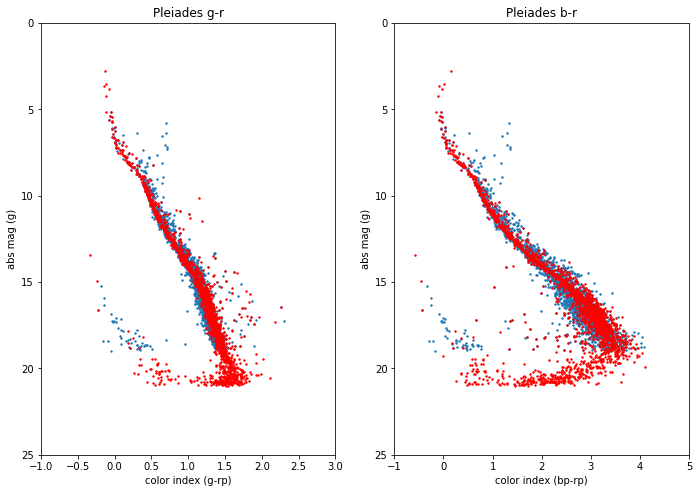

In [160]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.scatter(p['g_rp'], p['phot_g_mean_mag'], s=2)
ax.scatter(asu['G-R'], asu['Gmag'], s=2, color='red')
ax.set_xlim(-1, 3)
ax.set_ylim(25, 0)
ax.set_title('Pleiades g-r')
ax.set_xlabel("color index (g-rp)")
ax.set_ylabel("abs mag (g)")

ax2 = fig.add_subplot(122)
ax2.scatter(p['bp_rp'], p['phot_g_mean_mag'], s=2)
ax2.scatter(asu['B-R'], asu['Gmag'], s=2, color='red')
ax2.set_xlim(-1, 5)
ax2.set_ylim(25, 0)
ax2.set_title('Pleiades b-r')
ax2.set_xlabel("color index (bp-rp)")
ax2.set_ylabel("abs mag (g)")


plt.subplots_adjust(0.2, 0.2, 1.7, 1.7)
plt.show()

In [161]:
from scipy.signal import find_peaks
count, division = np.histogram(pleiades['pmra'], bins=100)
peaks, props = find_peaks(count)
temp = []
for i in peaks:
    if count[i] > 300: #num in cluster, argument
        temp.append([division[i], count[i]])
        
i = 0
index = 0
best_index = 0
for t in temp:
    print(abs(t[0]))
    if abs(t[0]) > i:
        i = abs(t[0])
        print(i)
        best_index = index
    index += 1
print(i)
print(best_index)
    
#print(division[])
print(temp[best_index][0])

4.8226551463375245
4.8226551463375245
15.804680756078596
15.804680756078596
15.804680756078596
1
15.804680756078596


In [162]:
count, division = np.histogram(pleiades['pmdec'], bins=100)
peaks, props = find_peaks(count)
temp = []
i = 0
index = 0
best_index = 0
for i in peaks:
    if count[i] > 300:  # num in cluster, argument
        temp.append([division[i], count[i]])

for t in temp:
    if abs(t[0]) > i:
        i = abs(t[0])
        best_index = index
    index += 1
print(temp[best_index][0])

-51.702397821141005


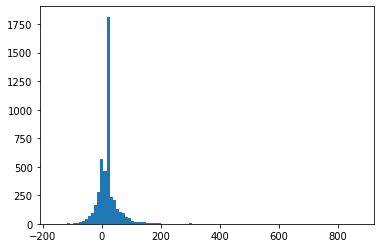

15.804680756078596


In [163]:
#plt.hist(pleiades['pmra'], bins=100)
n, b, patches = plt.hist(pleiades['pmra'], bins=100)
plt.show()
bin_max = np.where(n == n.max())
pmra_max = b[bin_max][0]
print(pmra_max)

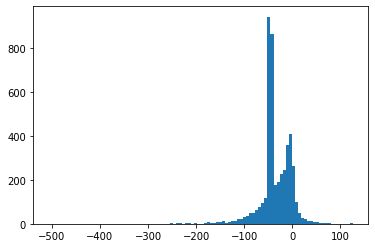

-51.702397821141005


In [164]:
#plt.hist(pleiades['pmra'], bins=100)
n, b, patches = plt.hist(pleiades['pmdec'], bins=100)
plt.show()
bin_max = np.where(n == n.max())
pmdec_max = b[bin_max][0]
print(pmdec_max)

In [165]:
from scipy.signal import find_peaks
count, division = np.histogram(pleiades['x'], bins=100)
peaks, props = find_peaks(count)
temp = []
for i in peaks:
    if count[i] > 50: #num in cluster, argument
        temp.append([division[i], count[i]])
    
i = 0
index = 0
best_index = 0
for t in temp:
    if abs(t[0]) > i:
        i = abs(t[0])
        best_index = index
    index += 1
    
#print(division[])
x_max = temp[best_index][0]
x_max

-140.0696527080598

In [166]:
from scipy.signal import find_peaks
count, division = np.histogram(pleiades['y'], bins=100)
peaks, props = find_peaks(count)
temp = []
for i in peaks:
    if count[i] > 50: #num in cluster, argument
        temp.append([division[i], count[i]])
    
i = 0
index = 0
best_index = 0
for t in temp:
    if abs(t[0]) > i:
        i = abs(t[0])
        best_index = index
    index += 1
    
y_max = temp[best_index][0]
y_max

37.82063295484637

In [167]:
from scipy.signal import find_peaks
count, division = np.histogram(pleiades['z'], bins=100)
peaks, props = find_peaks(count)
temp = []
for i in peaks:
    if count[i] > 50: #num in cluster, argument
        temp.append([division[i], count[i]])
    
i = 0
index = 0
best_index = 0
for t in temp:
    if abs(t[0]) > i:
        i = abs(t[0])
        best_index = index
    index += 1
    
z_max = temp[best_index][0]
z_max

-63.359544006172975

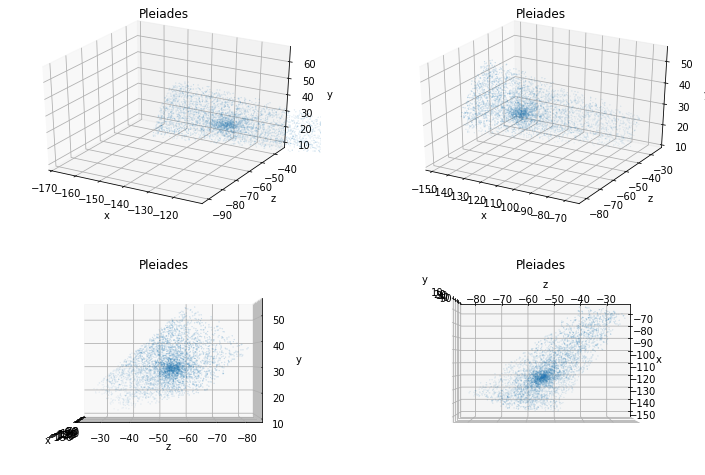

In [168]:
df = pleiades

fig = plt.figure()
ax = fig.add_subplot(221, projection ='3d')
ax.scatter(df['x'], df['z'], df['y'], s=0.01)
#if x_max > 0:
#    ax.set_xlim(-(x_max), x_max)
#else:
ax.set_xlim(x_max-30, x_max+30)
ax.set_ylim(z_max-30, z_max+30)
ax.set_zlim(y_max-30, y_max+30)
"""
if z_max > 0:
    ax.set_ylim(-(z_max * 1.5), z_max * 1.5)
else:
    ax.set_ylim(z_max * 1.5, -(z_max * 1.5))
if y_max > 0:
    ax.set_zlim(-(y_max * 1.5), y_max * 1.5)
else:
    ax.set_zlim(y_max * 1.5, -(y_max * 1.5))
"""
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('y')
ax.set_title('Pleiades')

ax1 = fig.add_subplot(222, projection ='3d')
ax1.scatter(df['x'], df['z'], df['y'], s=0.01)
ax1.set_xlabel('x')
ax1.set_ylabel('z')
ax1.set_zlabel('y')
ax1.set_title('Pleiades')
#ax1.view_init(0, 90)

ax2 = fig.add_subplot(223, projection ='3d')
ax2.scatter(df['x'], df['z'], df['y'], s=0.01)
ax2.set_xlabel('x')
ax2.set_ylabel('z')
ax2.set_zlabel('y')
ax2.set_title('Pleiades')
ax2.view_init(0, 180)

ax3 = fig.add_subplot(224, projection ='3d')
ax3.scatter(df['x'], df['z'], df['y'], s=0.01)
ax3.set_xlabel('x')
ax3.set_ylabel('z')
ax3.set_zlabel('y')
ax3.set_title('Pleiades')
ax3.view_init(-90, 0)

plt.subplots_adjust(0.4, 0.4, 2, 2)
plt.show()

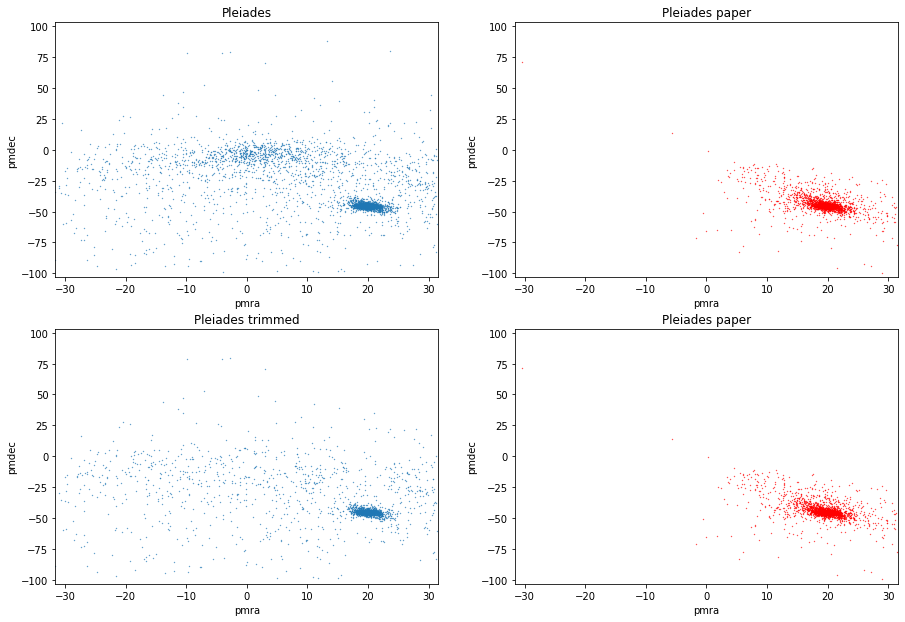

In [276]:
fig = plt.figure()
ax = fig.add_subplot(221)
ax.scatter(pleiades['pmra'], pleiades['pmdec'], s=0.1)
if pmra_max > 0:
    ax.set_xlim(-(pmra_max*2), pmra_max*2)
else:
    ax.set_xlim(pmra_max*2, -(pmra_max*2))
if pmdec_max > 0:
    ax.set_ylim(-(pmdec_max*2), pmdec_max*2)
else:
    ax.set_ylim(pmdec_max*2, -(pmdec_max*2))
ax.set_title('Pleiades')
ax.set_xlabel("pmra")
ax.set_ylabel("pmdec")

ax1 = fig.add_subplot(222)
ax1.scatter(asu['pmRACP'], asu['pmDECP'], s=0.1, color='red')
if pmra_max > 0:
    ax1.set_xlim(-(pmra_max*2), pmra_max*2)
else:
    ax1.set_xlim(pmra_max*2, -(pmra_max*2))
if pmdec_max > 0:
    ax1.set_ylim(-(pmdec_max*2), pmdec_max*2)
else:
    ax1.set_ylim(pmdec_max*2, -(pmdec_max*2))
ax1.set_title('Pleiades paper')
ax1.set_xlabel("pmra")
ax1.set_ylabel("pmdec")

ax2 = fig.add_subplot(223)
ax2.scatter(p['pmra'], p['pmdec'], s=0.1)
if pmra_max > 0:
    ax2.set_xlim(-(pmra_max*2), pmra_max*2)
else:
    ax2.set_xlim(pmra_max*2, -(pmra_max*2))
if pmdec_max > 0:
    ax2.set_ylim(-(pmdec_max*2), pmdec_max*2)
else:
    ax2.set_ylim(pmdec_max*2, -(pmdec_max*2))
ax2.set_title('Pleiades trimmed')
ax2.set_xlabel("pmra")
ax2.set_ylabel("pmdec")

ax3 = fig.add_subplot(224)
ax3.scatter(asu['pmRACP'], asu['pmDECP'], s=0.1, color='red')
if pmra_max > 0:
    ax3.set_xlim(-(pmra_max*2), pmra_max*2)
else:
    ax3.set_xlim(pmra_max*2, -(pmra_max*2))
if pmdec_max > 0:
    ax3.set_ylim(-(pmdec_max*2), pmdec_max*2)
else:
    ax3.set_ylim(pmdec_max*2, -(pmdec_max*2))
ax3.set_title('Pleiades paper')
ax3.set_xlabel("pmra")
ax3.set_ylabel("pmdec")

plt.subplots_adjust(0.05, 0.05, 2, 2)
plt.show()

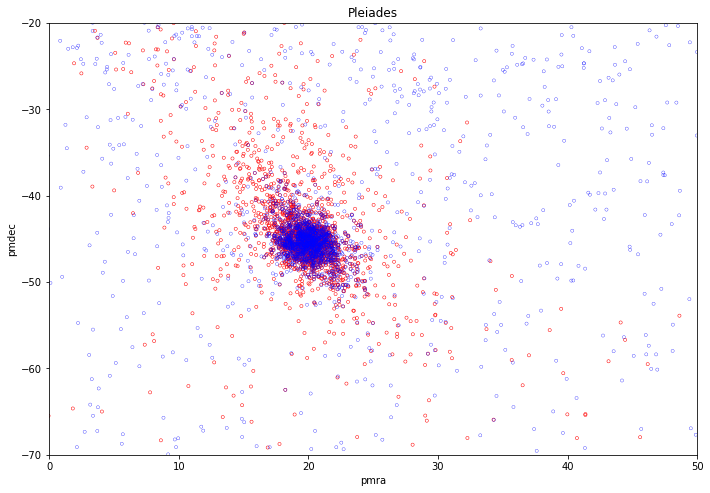

In [170]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.scatter(asu['pmRACP'], asu['pmDECP'], s=10, marker='o', facecolors='none', edgecolors='r', linewidths=0.5)
ax.scatter(pleiades['pmra'], pleiades['pmdec'], s=10, marker='o', facecolors='none', edgecolors='b', linewidths=0.3)
ax.set_facecolor('none')
ax.set_xlim(0, 50)
ax.set_ylim(-70, -20)
ax.set_title('Pleiades')
ax.set_xlabel("pmra")
ax.set_ylabel("pmdec")

plt.subplots_adjust(0.2, 0.2, 1.7, 1.7)
plt.show()

In [171]:
# Stars total in ASU between 19 and 5 gmag
count = 0
arr = []
for star in asu.itertuples():
    if star.Gmag <= 19 and star.Gmag >= 5:
        arr.append([star.RA_ICRS, star.DE_ICRS])
        count += 1
print(count)

data = np.array(arr)

df_hr_asu = pd.DataFrame(data, columns=['ra', 'dec'])
df_hr_asu = df_hr_asu.round(4)
df_hr_asu.head(10)

1811


,ra,dec
0,40.9750,22.6558
1,42.2429,27.0338
2,43.0540,24.5381
3,43.1052,30.6208
4,43.5371,32.3360
5,43.9008,28.6683
6,44.6915,21.4703
7,45.0787,25.5889
8,45.0800,29.3456
9,45.3179,14.0652


In [172]:
# Stars in total my dataset between HR 19 and 5 gmag
count = 0
arr = []
for star in p.itertuples():
    if star.phot_g_mean_mag <= 19 and star.phot_g_mean_mag >= 5:
        arr.append([star.ra, star.dec])
        count += 1
print(count)

data = np.array(arr)

df_hr_pleiades = pd.DataFrame(data, columns=['ra', 'dec'])
df_hr_pleiades = df_hr_pleiades.round(4)
df_hr_pleiades

3089


,ra,dec
0,58.5370,28.8135
1,58.9345,29.7939
2,59.5074,29.0679
3,59.0416,28.8185
4,57.8933,28.7133
...,...,...
3084,53.0351,27.8383
3085,54.1778,28.3516
3086,53.2058,27.7328
3087,53.3452,27.4804


In [173]:
# Stars in common based on RA
correct = 0
incorrect = 0
mergedStuffRA = pd.merge(df_hr_pleiades, df_hr_asu, on=['ra'], how='inner')
pleiades_c = []
for star in mergedStuffRA.itertuples():
    if star.dec_x == star.dec_y: #compare DEC's of same RA's
        correct += 1
        pleiades_c.append(star)
    else:
        incorrect += 1
print("Stars in common RA: ", len(mergedStuffRA))
print("Pleiades correctly identified: ", correct)
print("Pleiades incorrectly identified: ", incorrect)

Stars in common RA:  1197
Pleiades correctly identified:  1055
Pleiades incorrectly identified:  142


In [174]:
p_temp = p.round(4)

pleiades_correct = pd.DataFrame(data=pleiades_c)

df_pc_id = pd.Series(list(pleiades_correct['ra']))
pleiades_f = []
for star in p_temp.itertuples():
    if star.ra in df_pc_id.unique():
        pleiades_f.append(star)
pleiades_final_ra = pd.DataFrame(data=pleiades_f)
print(len(pleiades_final_ra))

1083


In [175]:
# Stars in common based on DEC
correct = 0
incorrect = 0
mergedStuffDEC = pd.merge(df_hr_pleiades, df_hr_asu, on=['dec'], how='inner')
pleiades_c = []
for star in mergedStuffDEC.itertuples():
    if star.ra_x == star.ra_y: #compare RA's of same DEC
        correct += 1
        pleiades_c.append(star)
    else:
        incorrect += 1
print("Stars in common DEC: ", len(mergedStuffDEC))
print("Pleiades correctly identified: ", correct)
print("Pleiades incorrectly identified: ", incorrect)

Stars in common DEC:  1286
Pleiades correctly identified:  1055
Pleiades incorrectly identified:  231


In [176]:
p_temp = p.round(4)

pleiades_correct = pd.DataFrame(data=pleiades_c)

df_pc_id = pd.Series(list(pleiades_correct['dec']))
pleiades_f = []
for star in p_temp.itertuples():
    if star.dec in df_pc_id.unique():
        pleiades_f.append(star)
pleiades_final_dec = pd.DataFrame(data=pleiades_f)
print(len(pleiades_final_dec))

1077


In [177]:
# Compare combined RA with combined DEC

df_dec_id = pd.Series(list(pleiades_final_dec['dec']))
df_ra_id = pd.Series(list(pleiades_final_ra['ra']))
pleiades_temp = []
for star in p_temp.itertuples():
    if star.dec in df_dec_id.unique() and star.ra in df_ra_id.unique():
        pleiades_temp.append(star)
pleiades_final = pd.DataFrame(data=pleiades_temp)
print(len(pleiades_final))

#pleiades_final (dataframe) is my "correct" stars in the Pleiades based off of the paper

1055


# Machine Learning
### DBSCAN

In [178]:
import math
import csv
import random
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.cluster import DBSCAN
from sklearn import metrics
import numpy as np

df_pm = pleiades[['pmra', 'pmdec', 'source_id']]
X = df_pm.to_numpy()

db = DBSCAN(eps=5, min_samples=300).fit(X) #HERE
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

data = np.asarray(labels)
label = pd.DataFrame({'labels': data})
label.head(10)

data = np.asarray(core_samples_mask)
core = pd.DataFrame({'core_samples_mask': data})

df_pm.reset_index(drop=True, inplace=True)
label.reset_index(drop=True, inplace=True)
core.reset_index(drop=True, inplace=True)

frames = [df_pm, core, label]
df_pm_temp = pd.concat(frames, sort=False, axis=1)

### Using Proper Motion

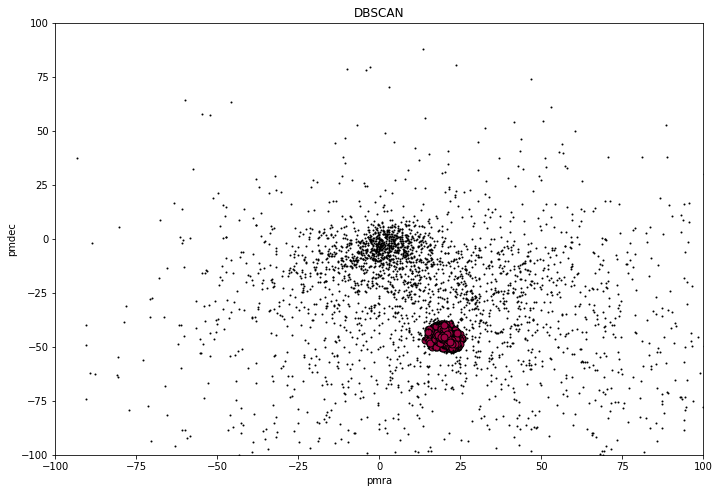

In [179]:
df = pleiades[['pmra', 'pmdec']]
X = df.to_numpy()

db = DBSCAN(eps=5, min_samples=300).fit(X) #HERE
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

data = np.asarray(labels)
label = pd.DataFrame({'labels': data})
label.head(10)

data = np.asarray(core_samples_mask)
core = pd.DataFrame({'core_samples_mask': data})

df.reset_index(drop=True, inplace=True)
label.reset_index(drop=True, inplace=True)
core.reset_index(drop=True, inplace=True)

frames = [df, core, label]
df_pm = pd.concat(frames, sort=False, axis=1)

# Number of clusters in labels, ignoring anomolies
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Black removed and is used for noise instead.
unique_labels = set(labels) #-1, 0, 1

#gives different colors to the different clusters, and black is for anamolies
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

#for each unique label, plot it with the color that corresponds to it
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=7)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=1)

#plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.title("DBSCAN")
plt.xlabel("pmra")
plt.ylabel("pmdec")
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.subplots_adjust(.5, .5, 2, 2)
plt.show()

In [180]:
anomaly = 0;
cluster = 0;

for i in labels:
    if i == 0:
        cluster += 1
    else:
        anomaly += 1
        
print("Anomaly: ", anomaly)
print("Pleiades: ", cluster)

Anomaly:  2915
Pleiades:  1665


In [181]:
df_temp = df_pm_temp[['source_id']]
frames = [df_temp, df_pm]
df_pm_final = pd.concat(frames, sort=False, axis=1)

In [182]:
# Compare to paper HR diagram

correct = 0
incorrect = 0
temp = []
df_p_id = pd.Series(list(pleiades_final['source_id']))
for star in df_pm_final.itertuples():
    if star.labels == 0:
        if star.source_id in df_p_id.unique():
            temp.append(star.source_id)
            correct += 1
        else:
            incorrect += 1
print("Pleiades correctly clustered: ", correct)
print("Pleiades incorrectly clustered: ", incorrect)

Pleiades correctly clustered:  1048
Pleiades incorrectly clustered:  617


### Using Position

In [183]:
df = pleiades[['x', 'y', 'z', 'source_id']]
X = df.to_numpy()

db = DBSCAN(eps=5, min_samples=300).fit(X) #HERE
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

data = np.asarray(labels)
label = pd.DataFrame({'labels': data})
label.head(10)

data = np.asarray(core_samples_mask)
core = pd.DataFrame({'core_samples_mask': data})

df.reset_index(drop=True, inplace=True)
label.reset_index(drop=True, inplace=True)
core.reset_index(drop=True, inplace=True)

frames = [df, core, label]
df_xyz_temp = pd.concat(frames, sort=False, axis=1)

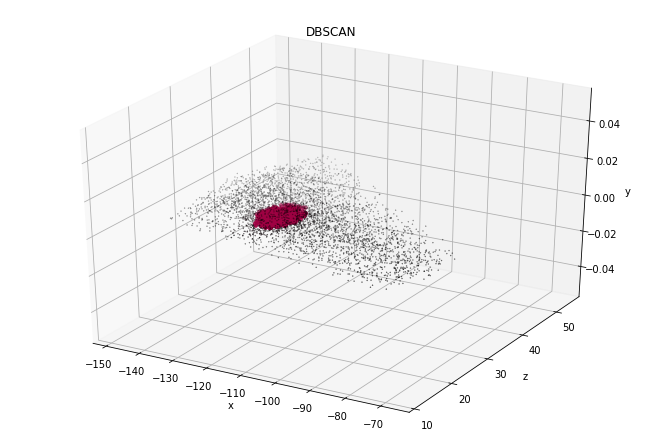

In [184]:
df = pleiades[['x', 'y', 'z']]
X = df.to_numpy()

db = DBSCAN(eps=5, min_samples=300).fit(X) #HERE
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

data = np.asarray(labels)
label = pd.DataFrame({'labels': data})
label.head(10)

data = np.asarray(core_samples_mask)
core = pd.DataFrame({'core_samples_mask': data})

df.reset_index(drop=True, inplace=True)
label.reset_index(drop=True, inplace=True)
core.reset_index(drop=True, inplace=True)

frames = [df, core, label]
df_xyz = pd.concat(frames, sort=False, axis=1)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Black removed and is used for noise instead.
unique_labels = set(labels) #-1, 0, 1

#gives different colors to the different clusters, and black is for anamolies
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

fig = plt.figure()
axp = fig.add_subplot(111, projection ='3d')

#for each unique label, plot it with the color that corresponds to it
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    axp.scatter(xy[:, 0], xy[:, 1], facecolor=tuple(col), s=10)

    xy = X[class_member_mask & ~core_samples_mask]
    axp.scatter(xy[:, 0], xy[:, 1], facecolor=tuple(col),
             edgecolor='k', s=0.1)

#plt.title('Estimated number of clusters: %d' % n_clusters_)

#axp.scatter(p['x'], p['z'], p['y'], s=1)
axp.set_xlabel('x')
axp.set_ylabel('z')
axp.set_zlabel('y')
#axp.set_zlim(-0.0001, 0)
#axp.set_xlim(-140, -180)
axp.set_title('DBSCAN')
plt.subplots_adjust(.5, .5, 2, 2)
plt.show()

In [185]:
anomaly = 0;
cluster = 0;

for i in labels:
    if i == 0:
        cluster += 1
    else:
        anomaly += 1
        
print("Anomaly: ", anomaly)
print("Pleiades: ", cluster)

Anomaly:  2972
Pleiades:  1608


In [186]:
df_temp = df_xyz_temp[['source_id']]
frames = [df_temp, df_xyz]
df_xyz_final = pd.concat(frames, sort=False, axis=1)

In [187]:
# Compare against the trimmed HR diagram

correct = 0
incorrect = 0
temp = []
df_p_id = pd.Series(list(p['source_id']))
for star in df_xyz_final.itertuples():
    if star.labels == 0:
        if star.source_id in df_p_id.unique():
            temp.append(star.source_id)
            correct += 1
        else:
            incorrect += 1
print("Pleiades correctly clustered: ", correct) # Correct == HR digram
print("Pleiades incorrectly clustered: ", incorrect)

Pleiades correctly clustered:  1285
Pleiades incorrectly clustered:  323


In [188]:
# Compare to paper HR diagram

correct = 0
incorrect = 0
temp = []
df_p_id = pd.Series(list(pleiades_final['source_id']))
for star in df_xyz_final.itertuples():
    if star.labels == 0:
        if star.source_id in df_p_id.unique():
            temp.append(star.source_id)
            correct += 1
        else:
            incorrect += 1
print("Pleiades correctly clustered: ", correct)
print("Pleiades incorrectly clustered: ", incorrect)

Pleiades correctly clustered:  849
Pleiades incorrectly clustered:  759


### Using Position and Proper Motion

In [189]:
df = pleiades[['x', 'y', 'z', 'pmra', 'pmdec', 'source_id']]
X = df.to_numpy()
#X.astype(np.float32)
#print(X)

db = DBSCAN(eps=5, min_samples=300).fit(X) #HERE
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

data = np.asarray(labels)
label = pd.DataFrame({'labels': data})
label.head(10)

data = np.asarray(core_samples_mask)
core = pd.DataFrame({'core_samples_mask': data})

df.reset_index(drop=True, inplace=True)
label.reset_index(drop=True, inplace=True)
core.reset_index(drop=True, inplace=True)

frames = [df, core, label]
df_all_temp = pd.concat(frames, sort=False, axis=1)

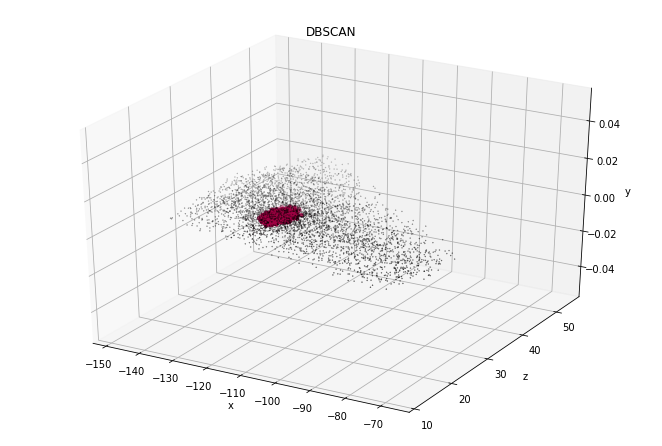

In [190]:
df = pleiades[['x', 'y', 'z', 'pmra', 'pmdec']]
X = df.to_numpy()
#X.astype(np.float32)
#print(X)

db = DBSCAN(eps=5, min_samples=300).fit(X) #HERE
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

data = np.asarray(labels)
label = pd.DataFrame({'labels': data})
label.head(10)

data = np.asarray(core_samples_mask)
core = pd.DataFrame({'core_samples_mask': data})

df.reset_index(drop=True, inplace=True)
label.reset_index(drop=True, inplace=True)
core.reset_index(drop=True, inplace=True)

frames = [df, core, label]
df_all = pd.concat(frames, sort=False, axis=1)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Black removed and is used for noise instead.
unique_labels = set(labels) #-1, 0, 1

#gives different colors to the different clusters, and black is for anamolies
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

fig = plt.figure()
axp = fig.add_subplot(111, projection ='3d')

#for each unique label, plot it with the color that corresponds to it
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    axp.scatter(xy[:, 0], xy[:, 1], facecolor=tuple(col), s=10)

    xy = X[class_member_mask & ~core_samples_mask]
    axp.scatter(xy[:, 0], xy[:, 1], facecolor=tuple(col),
             edgecolor='k', s=0.1)

#plt.title('Estimated number of clusters: %d' % n_clusters_)

#axp.scatter(p['x'], p['z'], p['y'], s=1)
axp.set_xlabel('x')
axp.set_ylabel('z')
axp.set_zlabel('y')
#axp.set_zlim(-0.0001, 0)
#axp.set_xlim(-140, -180)
axp.set_title('DBSCAN')
plt.subplots_adjust(.5, .5, 2, 2)
plt.show()

In [191]:
anomaly = 0;
cluster = 0;

for i in labels:
    if i == 0:
        cluster += 1
    else:
        anomaly += 1
        
print("Anomaly: ", anomaly)
print("Pleiades: ", cluster)

Anomaly:  3461
Pleiades:  1119


In [192]:
df_temp = df_all_temp[['source_id']]
frames = [df_temp, df_all]
df_all_final = pd.concat(frames, sort=False, axis=1)
df_all_final.head(10)

,source_id,x,y,z,pmra,pmdec,core_samples_mask,labels
0,167067944280305408,-123.502433,33.476218,-42.527861,-17.068992,-83.278437,False,-1
1,167029010399337728,-115.847115,32.237850,-41.335302,-38.001191,-37.906455,False,-1
2,167120613462491008,-142.587569,39.329845,-47.926941,-11.749665,-11.861530,False,-1
3,167101445023931520,-126.453867,34.295389,-42.582764,3.317155,-5.787608,False,-1
4,167192841928924288,-81.159023,23.236853,-27.449650,31.464230,-60.268502,False,-1
5,167170782976896384,-110.424553,30.840682,-37.157869,4.039593,-3.544305,False,-1
6,167092786371067264,-144.147570,38.822115,-49.105125,3.084010,-58.440843,False,-1
7,167174356389697024,-127.279786,35.753262,-42.983396,12.581656,-23.692416,False,-1
8,167060591296285952,-137.876687,37.485976,-48.273725,14.390535,-13.021398,False,-1
9,167009979401844352,-96.496368,27.529445,-35.382884,-1.610984,0.480614,False,-1


In [193]:
# Compare to trimmed HR diagram

correct = 0
incorrect = 0
temp = []
df_p_id = pd.Series(list(p['source_id']))
for star in df_all_final.itertuples():
    if star.labels == 0:
        if star.source_id in df_p_id.unique():
            temp.append(star.source_id)
            correct += 1
        else:
            incorrect += 1
print("Pleiades correctly clustered: ", correct) # Correct == x,y,z,pm plot
print("Pleiades incorrectly clustered: ", incorrect)

Pleiades correctly clustered:  990
Pleiades incorrectly clustered:  129


In [194]:
# Compare to paper HR diagram

correct = 0
incorrect = 0
temp = []
df_p_id = pd.Series(list(pleiades_final['source_id']))
for star in df_all_final.itertuples():
    if star.labels == 0:
        if star.source_id in df_p_id.unique():
            temp.append(star.source_id)
            correct += 1
        else:
            incorrect += 1
print("Pleiades correctly clustered: ", correct) # Correct == x,y,z,pm plot
print("Pleiades incorrectly clustered: ", incorrect)

Pleiades correctly clustered:  780
Pleiades incorrectly clustered:  339


### Using Position, Proper Motion, and RA and DEC

In [195]:
df = pleiades[['x', 'y', 'z', 'pmra', 'pmdec', 'ra', 'dec', 'source_id']]
X = df.to_numpy()
#X.astype(np.float32)
#print(X)

db = DBSCAN(eps=5, min_samples=300).fit(X) #HERE
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

data = np.asarray(labels)
label = pd.DataFrame({'labels': data})
label.head(10)

data = np.asarray(core_samples_mask)
core = pd.DataFrame({'core_samples_mask': data})

df.reset_index(drop=True, inplace=True)
label.reset_index(drop=True, inplace=True)
core.reset_index(drop=True, inplace=True)

frames = [df, core, label]
df_multiple_temp = pd.concat(frames, sort=False, axis=1)

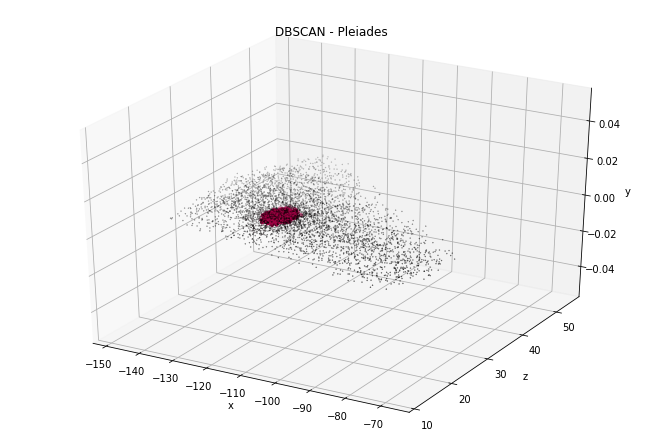

In [196]:
df = pleiades[['x', 'y', 'z', 'pmra', 'pmdec', 'ra', 'dec']]
X = df.to_numpy()
#X.astype(np.float32)
#print(X)

db = DBSCAN(eps=5, min_samples=300).fit(X) #HERE
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

data = np.asarray(labels)
label = pd.DataFrame({'labels': data})
label.head(10)

data = np.asarray(core_samples_mask)
core = pd.DataFrame({'core_samples_mask': data})

df.reset_index(drop=True, inplace=True)
label.reset_index(drop=True, inplace=True)
core.reset_index(drop=True, inplace=True)

frames = [df, core, label]
df_multiple = pd.concat(frames, sort=False, axis=1)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Black removed and is used for noise instead.
unique_labels = set(labels) #-1, 0, 1

#gives different colors to the different clusters, and black is for anamolies
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

fig = plt.figure()
axp = fig.add_subplot(111, projection ='3d')

#for each unique label, plot it with the color that corresponds to it
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    axp.scatter(xy[:, 0], xy[:, 1], facecolor=tuple(col), s=10)

    xy = X[class_member_mask & ~core_samples_mask]
    axp.scatter(xy[:, 0], xy[:, 1], facecolor=tuple(col),
             edgecolor='k', s=0.1)

axp.set_xlabel('x')
axp.set_ylabel('z')
axp.set_zlabel('y')
axp.set_title('DBSCAN - Pleiades')
plt.subplots_adjust(.5, .5, 2, 2)
plt.show()

In [197]:
anomaly = 0;
cluster = 0;

for i in labels:
    if i == 0:
        cluster += 1
    else:
        anomaly += 1
        
print("Anomaly: ", anomaly)
print("Pleiades: ", cluster)

Anomaly:  3529
Pleiades:  1051


In [198]:
df_temp = df_multiple_temp[['source_id']]
frames = [df_temp, df_multiple]
df_multiple_final = pd.concat(frames, sort=False, axis=1)
df_multiple_final.head(10)

,source_id,x,y,z,pmra,pmdec,ra,dec,core_samples_mask,labels
0,167067944280305408,-123.502433,33.476218,-42.527861,-17.068992,-83.278437,59.296331,28.998376,False,-1
1,167029010399337728,-115.847115,32.237850,-41.335302,-38.001191,-37.906455,58.537036,28.813519,False,-1
2,167120613462491008,-142.587569,39.329845,-47.926941,-11.749665,-11.861530,59.428710,29.478845,False,-1
3,167101445023931520,-126.453867,34.295389,-42.582764,3.317155,-5.787608,59.586007,29.282128,False,-1
4,167192841928924288,-81.159023,23.236853,-27.449650,31.464230,-60.268502,58.934499,29.793913,False,-1
5,167170782976896384,-110.424553,30.840682,-37.157869,4.039593,-3.544305,59.277768,29.594914,False,-1
6,167092786371067264,-144.147570,38.822115,-49.105125,3.084010,-58.440843,59.507422,29.067869,False,-1
7,167174356389697024,-127.279786,35.753262,-42.983396,12.581656,-23.692416,59.167402,29.610862,False,-1
8,167060591296285952,-137.876687,37.485976,-48.273725,14.390535,-13.021398,59.041621,28.818481,False,-1
9,167009979401844352,-96.496368,27.529445,-35.382884,-1.610984,0.480614,57.893316,28.713266,False,-1


In [199]:
# Compare to trimmed HR diagram
correct = 0
incorrect = 0
temp = []
df_p_id = pd.Series(list(p['source_id']))
for star in df_multiple_final.itertuples():
    if star.labels == 0:
        if star.source_id in df_p_id.unique():
            temp.append(star.source_id)
            correct += 1
        else:
            incorrect += 1
print("Pleiades correctly clustered: ", correct) # Correct == x,y,z,pm plot
print("Pleiades incorrectly clustered: ", incorrect)

Pleiades correctly clustered:  931
Pleiades incorrectly clustered:  120


In [200]:
# Compare to paper HR diagram

correct = 0
incorrect = 0
temp = []
df_p_id = pd.Series(list(pleiades_final['source_id']))
for star in df_multiple_final.itertuples():
    if star.labels == 0:
        if star.source_id in df_p_id.unique():
            temp.append(star.source_id)
            correct += 1
        else:
            incorrect += 1
print("Pleiades correctly clustered: ", correct) # Correct == x,y,z,pm plot
print("Pleiades incorrectly clustered: ", incorrect)

Pleiades correctly clustered:  735
Pleiades incorrectly clustered:  316


# phot_g_mean_mag

In [239]:
df = pleiades[['x', 'y', 'z', 'pmra', 'pmdec', 'phot_g_mean_mag', 'source_id']]
X = df.to_numpy()
#X.astype(np.float32)
#print(X)

db = DBSCAN(eps=7, min_samples=300).fit(X) #HERE
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

data = np.asarray(labels)
label = pd.DataFrame({'labels': data})
label.head(10)

data = np.asarray(core_samples_mask)
core = pd.DataFrame({'core_samples_mask': data})

df.reset_index(drop=True, inplace=True)
label.reset_index(drop=True, inplace=True)
core.reset_index(drop=True, inplace=True)

frames = [df, core, label]
df_gmag_temp = pd.concat(frames, sort=False, axis=1)

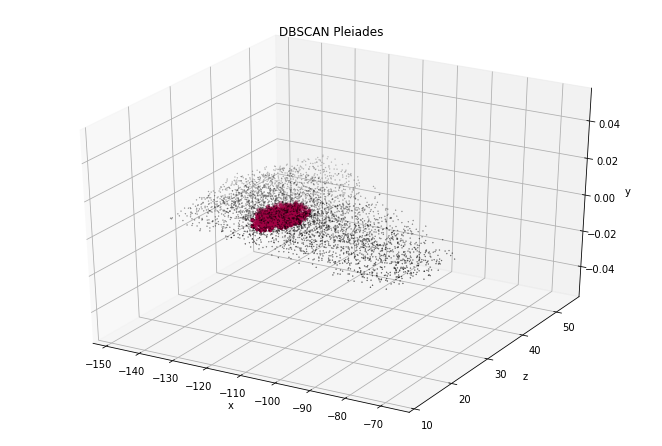

In [277]:
df = pleiades[['x', 'y', 'z', 'pmra', 'pmdec', 'phot_g_mean_mag']]
X = df.to_numpy()
#X.astype(np.float32)
#print(X)

db = DBSCAN(eps=7, min_samples=300).fit(X) #HERE
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

data = np.asarray(labels)
label = pd.DataFrame({'labels': data})
label.head(10)

data = np.asarray(core_samples_mask)
core = pd.DataFrame({'core_samples_mask': data})

df.reset_index(drop=True, inplace=True)
label.reset_index(drop=True, inplace=True)
core.reset_index(drop=True, inplace=True)

frames = [df, core, label]
df_gmag = pd.concat(frames, sort=False, axis=1)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Black removed and is used for noise instead.
unique_labels = set(labels) #-1, 0, 1

#gives different colors to the different clusters, and black is for anamolies
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

fig = plt.figure()
axp = fig.add_subplot(111, projection ='3d')

#for each unique label, plot it with the color that corresponds to it
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    axp.scatter(xy[:, 0], xy[:, 1], facecolor=tuple(col), s=10)

    xy = X[class_member_mask & ~core_samples_mask]
    axp.scatter(xy[:, 0], xy[:, 1], facecolor=tuple(col),
             edgecolor='k', s=0.1)

axp.set_xlabel('x')
axp.set_ylabel('z')
axp.set_zlabel('y')
axp.set_title('DBSCAN Pleiades')
plt.subplots_adjust(.5, .5, 2, 2)
plt.show()

In [241]:
anomaly = 0;
cluster = 0;

for i in labels:
    if i == 0:
        cluster += 1
    else:
        anomaly += 1
        
print("Anomaly: ", anomaly)
print("Pleiades: ", cluster)

Anomaly:  3257
Pleiades:  1323


In [242]:
df_temp = df_gmag_temp[['source_id']]
frames = [df_temp, df_gmag]
df_gmag_final = pd.concat(frames, sort=False, axis=1)

In [246]:
# Compare to trimmed HR diagram
correct = 0
incorrect = 0
cluster = 0
temp = []
df_p_id = pd.Series(list(p['source_id']))
for star in df_gmag_final.itertuples():
    if star.labels == 0:
        cluster += 1
        if star.source_id in df_p_id.unique():
            temp.append(star.source_id)
            correct += 1
        else:
            incorrect += 1
print("Pleiades correctly clustered: ", correct) # Correct == x,y,z,pm plot
print("Pleiades incorrectly clustered: ", incorrect)
print(cluster)

Pleiades correctly clustered:  1152
Pleiades incorrectly clustered:  171
1323


In [248]:
correct = 0
incorrect = 0
cluster = 0
temp = []
i = list(df_gmag_final)
temp_hr = pd.DataFrame(columns=i)
df_p_id = pd.Series(list(p['source_id']))
for index, row in df_gmag_final.iterrows():
    if row['labels'] == 0:
        cluster += 1
        temp_hr.loc[index] = (row)
        if row['source_id'] in df_p_id.unique():
            temp.append(row['source_id'])
            correct += 1
        else:
            incorrect += 1
print("Pleiades correctly clustered: ", correct)
print("Pleiades incorrectly clustered: ", incorrect)
print(cluster)

Pleiades correctly clustered:  1152
Pleiades incorrectly clustered:  171
1323


In [249]:
print(len(temp_hr))

1323


In [251]:
df_temp = temp_hr[['source_id']]
print(len(df_temp))
frames = [p, df_temp]
df_gmag = pd.merge(left=df_temp, right=p, how='left', left_on='source_id', right_on='source_id')
#df_gmag = pd.concat(frames, sort=False, axis=1, join='right')
print(len(df_gmag))
df_gmag.head(10)

1323
1323


,source_id,solution_id,designation,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,epoch_photometry_url,parallax_arcsec,R,x,y,z,magnitude,luminosity,solar_luminosity,radius
0,69409424578948608,1.635721e+18,Gaia DR2 69409424578948608,9.887355e+08,2015.5,53.959612,0.078030,25.705596,0.050219,7.398162,...,NaN,0.007398,135.168710,-118.316000,35.393853,-54.947061,10.222019,3.645140e+06,9.522310e-21,-0.799297
1,69351219182301184,1.635721e+18,Gaia DR2 69351219182301184,5.784426e+08,2015.5,53.556175,0.098113,25.423586,0.070924,7.326185,...,NaN,0.007326,136.496694,-118.989480,35.843071,-56.463487,11.287659,3.971584e+06,1.037509e-20,-0.921324
2,69448899622936704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,69461784523819904,1.635721e+18,Gaia DR2 69461784523819904,1.284932e+09,2015.5,53.769685,0.256216,25.846559,0.176310,7.827123,...,NaN,0.007827,127.760866,-111.688340,33.927050,-51.937549,12.674798,3.734555e+06,9.755891e-21,NaN
4,69252293199079424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,69545935818482560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,69486733990130048,1.635721e+18,Gaia DR2 69486733990130048,3.701961e+08,2015.5,53.673165,0.179864,26.157441,0.121530,7.425472,...,NaN,0.007425,134.671571,-117.715099,36.408884,-54.350535,12.016555,4.025544e+06,1.051605e-20,NaN
7,69400010010608768,1.635721e+18,Gaia DR2 69400010010608768,1.604130e+09,2015.5,54.350687,0.049347,25.722130,0.029323,7.580527,...,NaN,0.007581,131.916953,-115.852884,34.032935,-53.122041,8.963526,3.185095e+06,8.320521e-21,-0.860825
8,69250235911393408,1.635721e+18,Gaia DR2 69250235911393408,4.955571e+08,2015.5,53.507632,0.056586,24.880712,0.031110,7.105271,...,NaN,0.007105,140.740590,-122.470350,36.090962,-59.214607,4.978248,2.668440e+06,6.970845e-21,-1.185699
9,69294319455655808,1.635721e+18,Gaia DR2 69294319455655808,9.110600e+08,2015.5,53.983631,0.065646,25.366363,0.050411,7.454241,...,NaN,0.007454,134.151817,-117.355860,34.535008,-55.060378,9.539958,3.432542e+06,8.966933e-21,-0.792939


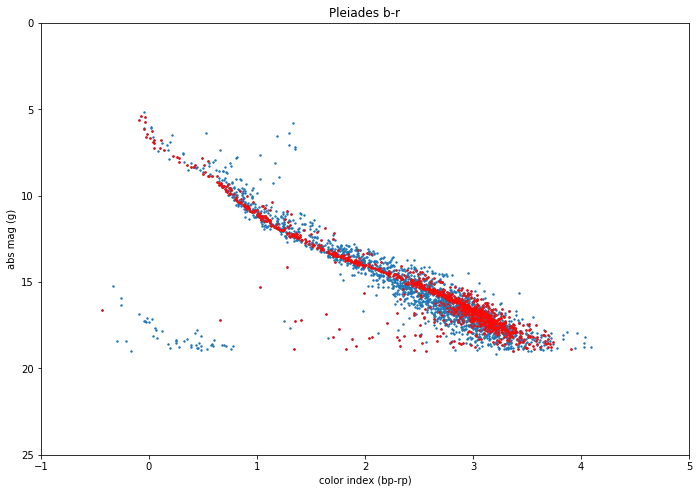

In [259]:
plt.scatter(p['bp_rp'], p['phot_g_mean_mag'], s=2)
plt.scatter(df_gmag['bp_rp'], df_gmag['phot_g_mean_mag'], s=2, edgecolors='r', marker="o", facecolors=None)
plt.xlim(-1, 5)
plt.ylim(25, 0)
plt.title('Pleiades b-r')
plt.xlabel("color index (bp-rp)")
plt.ylabel("abs mag (g)")

plt.subplots_adjust(0.2, 0.2, 1.7, 1.7)
plt.show()

In [206]:
# Compare to paper HR diagram

correct = 0
incorrect = 0
temp = []
df_p_id = pd.Series(list(pleiades_final['source_id']))
for star in df_gmag_final.itertuples():
    if star.labels == 0:
        if star.source_id in df_p_id.unique():
            temp.append(star.source_id)
            correct += 1
        else:
            incorrect += 1
print("Pleiades correctly clustered: ", correct)
print("Pleiades incorrectly clustered: ", incorrect)

Pleiades correctly clustered:  906
Pleiades incorrectly clustered:  417


In [254]:
correct = 0
incorrect = 0
cluster = 0
temp = []
i = list(df_gmag_final)
temp_hr = pd.DataFrame(columns=i)
df_p_id = pd.Series(list(pleiades_final['source_id']))
for index, row in df_gmag_final.iterrows():
    if row['labels'] == 0:
        cluster += 1
        temp_hr.loc[index] = (row)
        if row['source_id'] in df_p_id.unique():
            temp.append(row['source_id'])
            correct += 1
        else:
            incorrect += 1
print("Pleiades correctly clustered: ", correct)
print("Pleiades incorrectly clustered: ", incorrect)
print(cluster)

Pleiades correctly clustered:  906
Pleiades incorrectly clustered:  417
1323


In [255]:
df_temp = temp_hr[['source_id']]
print(len(df_temp))
frames = [p, df_temp]
df_gmag = pd.merge(left=df_temp, right=p, how='left', left_on='source_id', right_on='source_id')
#df_gmag = pd.concat(frames, sort=False, axis=1, join='right')
print(len(df_gmag))
df_gmag.head(10)

1323
1323


,source_id,solution_id,designation,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,epoch_photometry_url,parallax_arcsec,R,x,y,z,magnitude,luminosity,solar_luminosity,radius
0,69409424578948608,1.635721e+18,Gaia DR2 69409424578948608,9.887355e+08,2015.5,53.959612,0.078030,25.705596,0.050219,7.398162,...,NaN,0.007398,135.168710,-118.316000,35.393853,-54.947061,10.222019,3.645140e+06,9.522310e-21,-0.799297
1,69351219182301184,1.635721e+18,Gaia DR2 69351219182301184,5.784426e+08,2015.5,53.556175,0.098113,25.423586,0.070924,7.326185,...,NaN,0.007326,136.496694,-118.989480,35.843071,-56.463487,11.287659,3.971584e+06,1.037509e-20,-0.921324
2,69448899622936704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,69461784523819904,1.635721e+18,Gaia DR2 69461784523819904,1.284932e+09,2015.5,53.769685,0.256216,25.846559,0.176310,7.827123,...,NaN,0.007827,127.760866,-111.688340,33.927050,-51.937549,12.674798,3.734555e+06,9.755891e-21,NaN
4,69252293199079424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,69545935818482560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,69486733990130048,1.635721e+18,Gaia DR2 69486733990130048,3.701961e+08,2015.5,53.673165,0.179864,26.157441,0.121530,7.425472,...,NaN,0.007425,134.671571,-117.715099,36.408884,-54.350535,12.016555,4.025544e+06,1.051605e-20,NaN
7,69400010010608768,1.635721e+18,Gaia DR2 69400010010608768,1.604130e+09,2015.5,54.350687,0.049347,25.722130,0.029323,7.580527,...,NaN,0.007581,131.916953,-115.852884,34.032935,-53.122041,8.963526,3.185095e+06,8.320521e-21,-0.860825
8,69250235911393408,1.635721e+18,Gaia DR2 69250235911393408,4.955571e+08,2015.5,53.507632,0.056586,24.880712,0.031110,7.105271,...,NaN,0.007105,140.740590,-122.470350,36.090962,-59.214607,4.978248,2.668440e+06,6.970845e-21,-1.185699
9,69294319455655808,1.635721e+18,Gaia DR2 69294319455655808,9.110600e+08,2015.5,53.983631,0.065646,25.366363,0.050411,7.454241,...,NaN,0.007454,134.151817,-117.355860,34.535008,-55.060378,9.539958,3.432542e+06,8.966933e-21,-0.792939


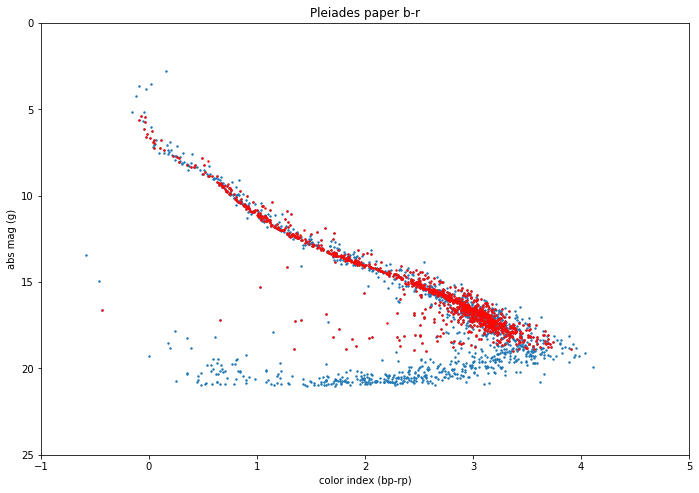

In [258]:
plt.scatter(asu['B-R'], asu['Gmag'], s=2)
plt.scatter(df_gmag['bp_rp'], df_gmag['phot_g_mean_mag'], s=2, edgecolors='r', marker="o", facecolors=None)
plt.xlim(-1, 5)
plt.ylim(25, 0)
plt.title('Pleiades paper b-r')
plt.xlabel("color index (bp-rp)")
plt.ylabel("abs mag (g)")

plt.subplots_adjust(0.2, 0.2, 1.7, 1.7)
plt.show()

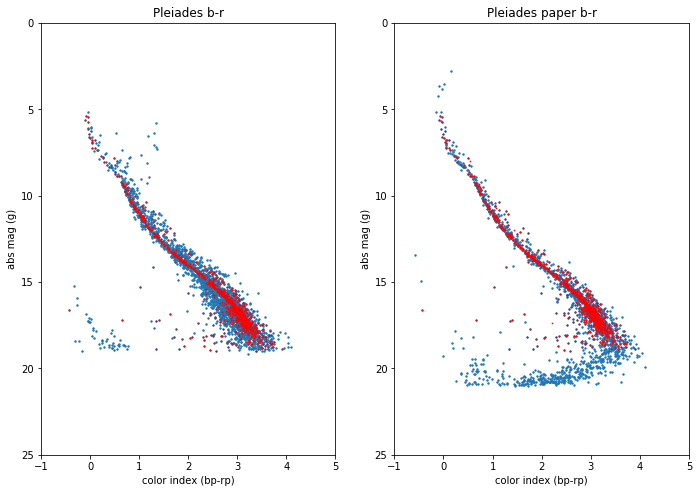

In [263]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.scatter(p['bp_rp'], p['phot_g_mean_mag'], s=2)
ax.scatter(df_gmag['bp_rp'], df_gmag['phot_g_mean_mag'], s=2, edgecolors='r', marker=".", facecolors=None)
ax.set_xlim(-1, 5)
ax.set_ylim(25, 0)
ax.set_title('Pleiades b-r')
ax.set_xlabel("color index (bp-rp)")
ax.set_ylabel("abs mag (g)")

ax2 = fig.add_subplot(122)
ax2.scatter(asu['B-R'], asu['Gmag'], s=2)
ax2.scatter(df_gmag['bp_rp'], df_gmag['phot_g_mean_mag'], s=2, edgecolors='r', marker=".", facecolors=None)
ax2.set_xlim(-1, 5)
ax2.set_ylim(25, 0)
ax2.set_title('Pleiades paper b-r')
ax2.set_xlabel("color index (bp-rp)")
ax2.set_ylabel("abs mag (g)")


plt.subplots_adjust(0.2, 0.2, 1.7, 1.7)
plt.show()

# Center of Pleiades

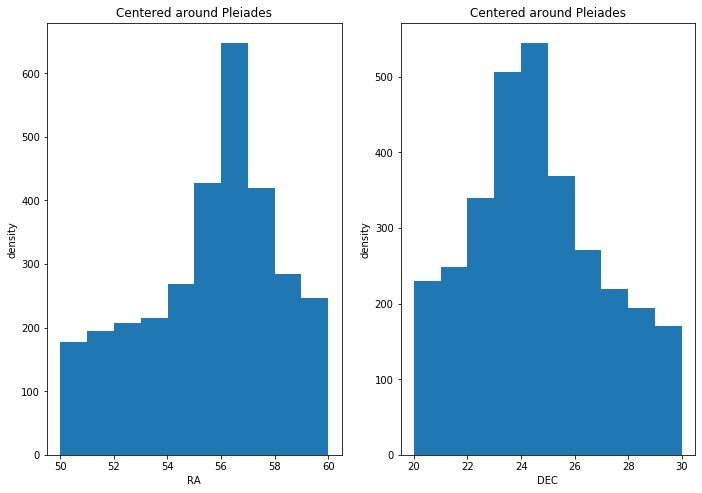

In [207]:
# Center around Pleiades
fig = plt.figure()
ax = fig.add_subplot(121)
ax.hist(p['ra'])
ax.set_title('Centered around Pleiades')
ax.set_xlabel("RA")
ax.set_ylabel("density")

ax2 = fig.add_subplot(122)
ax2.hist(p['dec'])
ax2.set_title('Centered around Pleiades')
ax2.set_xlabel("DEC")
ax2.set_ylabel("density")

plt.subplots_adjust(0.2, 0.2, 1.7, 1.7)
plt.show()

In [208]:
# Download data sets changing RA and DEC, see if you can still find Plieades
# Test what other parameters you can use (teff_val)

pleiadestest = pd.read_csv("pleiadestest.csv")
pleiadestest.loc[:, 'parallax_arcsec'] = pleiadestest['parallax'].apply(lambda x: x*.001)
pleiadestest.loc[:, 'R'] = pleiadestest['parallax_arcsec'].apply(distance)
pleiadestest.loc[:, 'x'] = pleiadestest.apply(lambda r: x(r['R'], r['b'], r['l']), axis=1)
pleiadestest.loc[:, 'y'] = pleiadestest.apply(lambda r: y(r['R'], r['b'], r['l']), axis=1)
pleiadestest.loc[:, 'z'] = pleiadestest.apply(lambda r: z(r['R'], r['b']), axis=1)
pleiadestest.loc[:, 'magnitude'] = pleiadestest.apply(lambda x: absmag(x['phot_g_mean_mag'], x['R']), axis=1)
pleiadestest.loc[:, 'luminosity'] = pleiadestest.apply(lambda x: luminosity(x['phot_g_mean_mag'], x['R']), axis=1)
pleiadestest.loc[:, 'solar_luminosity'] = pleiadestest.apply(lambda x: solar_lum(x['luminosity']), axis=1)
pleiadestest.loc[:, 'radius'] = pleiadestest.apply(lambda x: radius(x['luminosity'], x['teff_val']), axis=1)

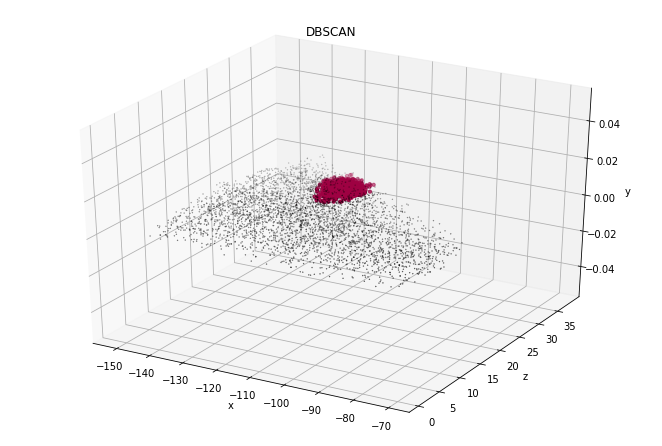

In [209]:
df = pleiadestest[['x', 'y', 'z', 'pmra', 'pmdec']]
X = df.to_numpy()

db = DBSCAN(eps=5, min_samples=100).fit(X) #HERE
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

data = np.asarray(labels)
label = pd.DataFrame({'labels': data})
label.head(10)

data = np.asarray(core_samples_mask)
core = pd.DataFrame({'core_samples_mask': data})

df.reset_index(drop=True, inplace=True)
label.reset_index(drop=True, inplace=True)
core.reset_index(drop=True, inplace=True)

frames = [df, core, label]
df_xyz = pd.concat(frames, sort=False, axis=1)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Black removed and is used for noise instead.
unique_labels = set(labels) #-1, 0, 1

#gives different colors to the different clusters, and black is for anamolies
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

fig = plt.figure()
axp = fig.add_subplot(111, projection ='3d')

#for each unique label, plot it with the color that corresponds to it
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    axp.scatter(xy[:, 0], xy[:, 1], facecolor=tuple(col), s=10)

    xy = X[class_member_mask & ~core_samples_mask]
    axp.scatter(xy[:, 0], xy[:, 1], facecolor=tuple(col),
             edgecolor='k', s=0.1)

#plt.title('Estimated number of clusters: %d' % n_clusters_)

#axp.scatter(p['x'], p['z'], p['y'], s=1)
axp.set_xlabel('x')
axp.set_ylabel('z')
axp.set_zlabel('y')
#axp.set_zlim(-0.0001, 0)
#axp.set_xlim(-140, -180)
axp.set_title('DBSCAN')
plt.subplots_adjust(.5, .5, 2, 2)
plt.show()